# Customer Intent Classification with Tensorflow

In [294]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [295]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


## Load the Datasets

In [296]:
df_train = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")


In [297]:
df_train.head()

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival


In [298]:
df_test.head()

,text,category
0,How do I locate my card?,card_arrival
1,"I still have not received my new card, I order...",card_arrival
2,I ordered a card but it has not arrived. Help ...,card_arrival
3,Is there a way to know when my card will arrive?,card_arrival
4,My card has not arrived yet.,card_arrival


## Check the Missing Values

In [299]:
df_train.isnull().sum()


text        0
category    0
dtype: int64

In [300]:
df_test.isnull().sum()

text        0
category    0
dtype: int64

In [301]:
df_train = df_train.dropna()
df_test = df_test.dropna()


## Check the Target Balance

In [302]:
unique_values = df_train["category"].unique()
value_counts = df_train["category"].value_counts()
print(unique_values)
print(value_counts)


['card_arrival' 'card_linking' 'exchange_rate'
 'card_payment_wrong_exchange_rate' 'extra_charge_on_statement'
 'pending_cash_withdrawal' 'fiat_currency_support'
 'card_delivery_estimate' 'automatic_top_up' 'card_not_working'
 'exchange_via_app' 'lost_or_stolen_card' 'age_limit' 'pin_blocked'
 'contactless_not_working' 'top_up_by_bank_transfer_charge'
 'pending_top_up' 'cancel_transfer' 'top_up_limits'
 'wrong_amount_of_cash_received' 'card_payment_fee_charged'
 'transfer_not_received_by_recipient' 'supported_cards_and_currencies'
 'getting_virtual_card' 'card_acceptance' 'top_up_reverted'
 'balance_not_updated_after_cheque_or_cash_deposit'
 'card_payment_not_recognised' 'edit_personal_details'
 'why_verify_identity' 'unable_to_verify_identity' 'get_physical_card'
 'visa_or_mastercard' 'topping_up_by_card' 'disposable_card_limits'
 'compromised_card' 'atm_support' 'direct_debit_payment_not_recognised'
 'passcode_forgotten' 'declined_cash_withdrawal' 'pending_card_payment'
 'lost_or_sto

## Display the Distribution of Labeled Intents

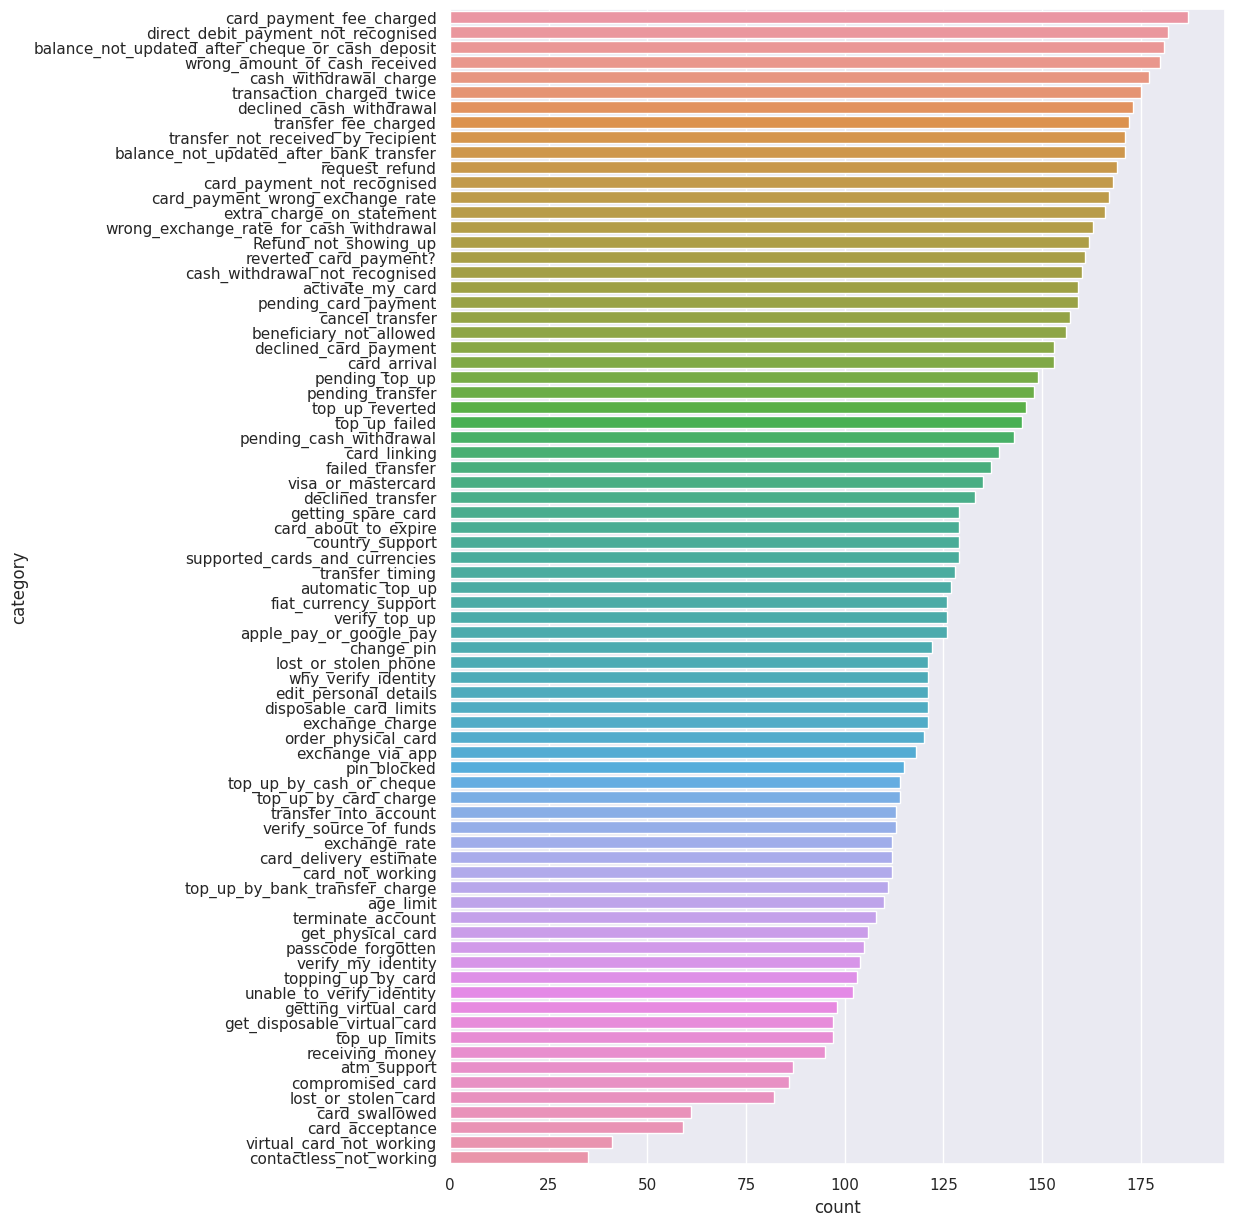

In [303]:
sns.set(rc={"figure.figsize":(10, 15)})
sns.countplot(data=df_train, y="category", order=df_train['category'].value_counts().index)
plt.show()


## Shuffle the Dataset

In [304]:
df_train = df_train.sample(frac = 1)

## Transform the Data

In [305]:
train_data = df_train['text'].to_numpy()
test_data = df_test['text'].to_numpy()

## Tokenize the Words

In [306]:
vocab_size = 5000
oov_tok = '<OOV>'


In [307]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_data)


In [308]:
train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)


## Pad the Training and Test Sequences

In [309]:
max_length = 50
trunc_type = 'post'
padding_type = 'post'


In [310]:
x_train = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

x_test = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


## Encode the Labels

In [311]:
train_labels = pd.Categorical(df_train['category']).codes
test_labels = pd.Categorical(df_test['category']).codes



In [312]:
y_train = train_labels.reshape((10003,1))
y_test = test_labels.reshape((3080,1))


## Prepare a Validation Set

In [313]:
partial_x_train = x_train[:9000]
partial_y_train = y_train[:9000]

x_val = x_train[9000:]
y_val = y_train[9000:]


## Define a Neural Network Architecture

In [314]:
embedding_dim = 64

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(77, activation='softmax')
])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          320000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 77)                5005      
                                                                 
Total params: 399309 (1.52 MB)
Trainable params: 399309 (1.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Fit the Model

In [315]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [285]:
num_epochs = 20

history = model.fit(partial_x_train, partial_y_train, epochs=num_epochs, validation_data=(x_val, y_val), verbose=2)


Epoch 1/20
282/282 - 19s - loss: 3.8078 - accuracy: 0.0644 - val_loss: 13.6971 - val_accuracy: 0.0000e+00 - 19s/epoch - 66ms/step
Epoch 2/20
282/282 - 13s - loss: 2.3287 - accuracy: 0.3296 - val_loss: 18.8184 - val_accuracy: 0.0050 - 13s/epoch - 47ms/step
Epoch 3/20
282/282 - 14s - loss: 1.3865 - accuracy: 0.5832 - val_loss: 21.4733 - val_accuracy: 0.0130 - 14s/epoch - 50ms/step
Epoch 4/20
282/282 - 13s - loss: 0.9316 - accuracy: 0.7269 - val_loss: 24.0095 - val_accuracy: 0.0269 - 13s/epoch - 48ms/step
Epoch 5/20
282/282 - 14s - loss: 0.6664 - accuracy: 0.8066 - val_loss: 25.2978 - val_accuracy: 0.0499 - 14s/epoch - 50ms/step
Epoch 6/20
282/282 - 13s - loss: 0.5329 - accuracy: 0.8516 - val_loss: 26.2684 - val_accuracy: 0.0518 - 13s/epoch - 48ms/step
Epoch 7/20
282/282 - 14s - loss: 0.4314 - accuracy: 0.8789 - val_loss: 25.9215 - val_accuracy: 0.0508 - 14s/epoch - 49ms/step
Epoch 8/20
282/282 - 14s - loss: 0.3540 - accuracy: 0.8999 - val_loss: 26.6298 - val_accuracy: 0.0578 - 14s/epoch 

## Plot Training and Validation Loss Curves

In [286]:
df_history = pd.DataFrame(history.history)
df_history.rename(columns ={"loss": "train_loss"}, inplace=True)


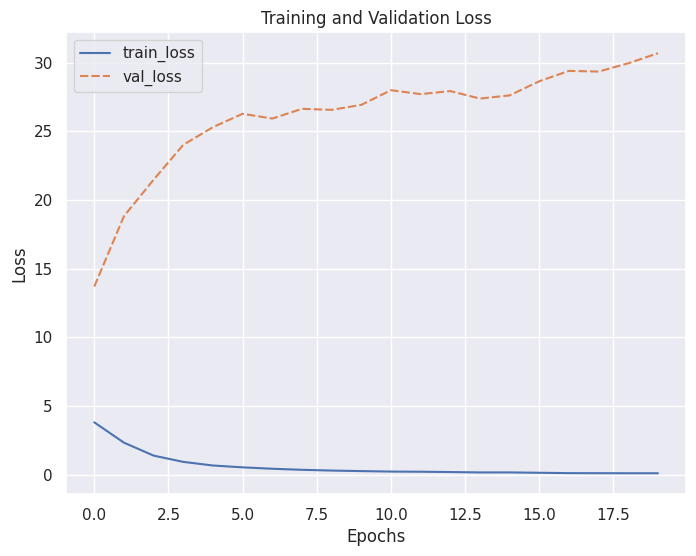

In [287]:
sns.set(rc={"figure.figsize":(8, 6)})
my_plot = sns.lineplot(data=df_history[["train_loss","val_loss"]])
my_plot.set_xlabel('Epochs')
my_plot.set_ylabel("Loss")
my_plot.set_title("Training and Validation Loss")
plt.show()

## Retrain the Model

In [288]:
# Epoch number may differ from your observation as the randomized training data.
num_epochs = 14  

model = tf.keras.Sequential([
 tf.keras.layers.Embedding(vocab_size, embedding_dim),
 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
 tf.keras.layers.Dense(embedding_dim, activation='relu'),
 tf.keras.layers.Dense(77, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=num_epochs, verbose=2)

Epoch 1/14
313/313 - 18s - loss: 3.6907 - accuracy: 0.1044 - 18s/epoch - 58ms/step
Epoch 2/14
313/313 - 15s - loss: 1.8382 - accuracy: 0.4876 - 15s/epoch - 47ms/step
Epoch 3/14
313/313 - 14s - loss: 1.0752 - accuracy: 0.6922 - 14s/epoch - 46ms/step
Epoch 4/14
313/313 - 15s - loss: 0.7375 - accuracy: 0.7906 - 15s/epoch - 48ms/step
Epoch 5/14
313/313 - 14s - loss: 0.5575 - accuracy: 0.8428 - 14s/epoch - 46ms/step
Epoch 6/14
313/313 - 15s - loss: 0.4434 - accuracy: 0.8727 - 15s/epoch - 48ms/step
Epoch 7/14
313/313 - 14s - loss: 0.3768 - accuracy: 0.8942 - 14s/epoch - 46ms/step
Epoch 8/14
313/313 - 15s - loss: 0.3163 - accuracy: 0.9096 - 15s/epoch - 48ms/step
Epoch 9/14
313/313 - 14s - loss: 0.2782 - accuracy: 0.9188 - 14s/epoch - 46ms/step
Epoch 10/14
313/313 - 15s - loss: 0.2422 - accuracy: 0.9304 - 15s/epoch - 48ms/step
Epoch 11/14
313/313 - 14s - loss: 0.2167 - accuracy: 0.9368 - 14s/epoch - 46ms/step
Epoch 12/14
313/313 - 15s - loss: 0.1916 - accuracy: 0.9445 - 15s/epoch - 49ms/step
E

## Examine the Model’s Performance with the Test Dataset

In [289]:
results = model.evaluate(x_test, y_test)

97/97 [==============================] - 2s 12ms/step - loss: 0.8162 - accuracy: 0.8224


## Predict the Outcomes for New Data

In [290]:
input_text = ["I am still waiting for my card, when will it arrive?",
                    "Which fiat currency do you support?",
                    "Help, I just lost my card!"]

input_text_arr = np.array(input_text)
input_text_sequences = tokenizer.texts_to_sequences(input_text_arr)
input_text_padded = pad_sequences(input_text_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [291]:
predictions = model.predict(input_text_padded)
predicted_classes = np.argmax(predictions,axis=1)

1/1 [==============================] - 1s 730ms/step


## Match Predictions with Severity Levels

In [292]:
df_train['category_codes'] = pd.Categorical(df_train['category']).codes
df_ref = df_train[["category", "category_codes"]]
df_ref = df_ref.drop_duplicates()
df_ref = df_ref.reset_index(drop=True)

predicted_categories = []

for x in predicted_classes:
  target_code = x
  category = df_ref[df_ref["category_codes"] == target_code]["category"].values[0]
  predicted_categories.append(category)

In [293]:
df_severity = pd.read_csv("./severity_levels.csv")

for y in predicted_categories:
  target_index = df_severity [df_severity ["category"]==y].index.values[0]
  level = df_severity._get_value(target_index, 'severity_level')
  print("Predicted Category: " + y)
  print("Severity Level: " + level )
  print("\n")


Predicted Category: card_arrival
Severity Level: Medium


Predicted Category: fiat_currency_support
Severity Level: Low


Predicted Category: lost_or_stolen_card
Severity Level: High


